# Cycle Benchmarking

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/qcvv/qcvv_cb_css.ipynb)
[![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supermarq/qcvv/qcvv_cb_css.ipynb)


[Cycle Benchmarking](https://www.nature.com/articles/s41467-019-13068-7) (CB) evaluates the process fidelity of a cycle of interest interleaved with uniformly drawn Pauli cycles.<br>
Similarly to [Interleaved Randomized Benchmarking](https://arxiv.org/abs/1203.4550), the process fidelity of the cycle alone can be estimated by comparing it with that of the Identity gate as computed with CB. 

In [1]:
import cirq
import cirq_superstaq as css
from supermarq.qcvv import CB

We illustrate this protocol with independant depolarizing noise channel applied to two qubits gates and/or one qubit.

In [2]:
class CustomDepolarizingNoiseModel(cirq.NoiseModel):
    def __init__(self, two_qubit_param: float, one_qubit_param: float | None = None) -> None:
        super().__init__()
        self.two_qubit_param = two_qubit_param
        self.one_qubit_param = one_qubit_param
        self.two_qubit_channel = cirq.DepolarizingChannel(p=self.two_qubit_param, n_qubits=2)
        self.one_qubit_channel = None
        if self.one_qubit_param is not None:
            self.one_qubit_channel = cirq.DepolarizingChannel(p=self.one_qubit_param, n_qubits=1)

    def noisy_operation(self, operation: cirq.Operation) -> cirq.OP_TREE:
        if isinstance(operation.gate, css.Barrier):
            return []
        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_channel(*operation.qubits)]
        if self.one_qubit_channel is not None and len(operation.qubits) == 1:
            return [operation, self.one_qubit_channel(*operation.qubits)]
        return [operation]

We first estimate the fidelity of the $CZ$ gate in a model where noise is only applied to two qubit gates.

In [3]:
p2 = 0.05
noise_model = CustomDepolarizingNoiseModel(two_qubit_param=p2)
simulator = cirq.DensityMatrixSimulator(noise=noise_model)

This noise channel is represented with the Kraus operators $\{E_i\}_{1 \leq i \leq 15}$ with $E_0 = \sqrt{1-p_2}I$ and $E_i = \sqrt{\frac{p2}{15}}P_i$ where $P_i$ is a non-Identity Pauli gate.

With this representation, the process fidelity $F$ is: 
$$F = \frac{1}{16}\sum{|Tr(E_i)|^2}=1-p_2$$
as only the Identity has non-zero trace.

In [4]:
q0, q1 = cirq.LineQubit.range(2)
process_circuit = cirq.Circuit(cirq.CZ(q0, q1))
cb = CB(
    process_circuit=process_circuit,
    pauli_channels=10,
    num_circuits=10,
    process_order_factors=[1, 5],
    random_seed=2,
)

Building circuits:   0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
results = cb.run_with_simulator(simulator)

Simulating circuits:   0%|          | 0/200 [00:00<?, ?it/s]

Cycle Benchmarking Results:
Estimated process fidelity: 0.94641 +/- 0.00061


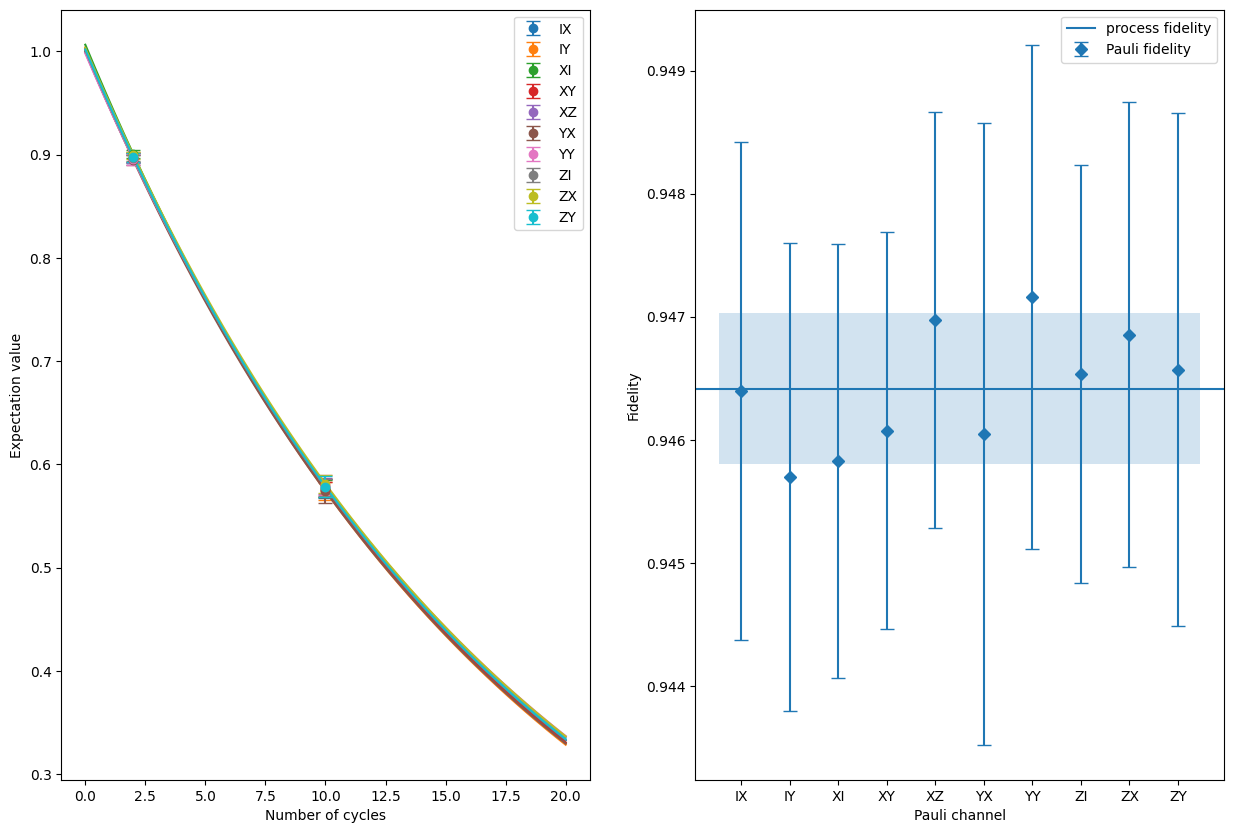

In [6]:
results.analyze()

The protocol correctly characterized the fidelity of the $CZ$ gate in the presence of this simple noise model. <br>
Let's add some noisy single qubit gates:

In [7]:
one_qubit_param = 0.01
two_qubit_param = 0.05
noise_model = CustomDepolarizingNoiseModel(
    one_qubit_param=one_qubit_param, two_qubit_param=two_qubit_param
)
simulator = cirq.DensityMatrixSimulator(noise=noise_model)

With this error model, the process fidelity of the $CZ$ gate dressed with random pauli gates is expected to be: 0.9301.<br>
The process fidelity of the $CZ$ gate alone can be estimated by taking the ratio of the dressed process' fidelity with the dressed Identity fidelity.

This can be done be done by setting the `undressed_process` flag to `True`.

In [8]:
q0, q1 = cirq.LineQubit.range(2)
process_circuit = cirq.Circuit(cirq.CZ(q0, q1))
cb = CB(
    process_circuit=process_circuit,
    pauli_channels=10,
    num_circuits=10,
    process_order_factors=[1, 5],
    random_seed=2,
    undressed_process=True,
)

Building circuits:   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
results = cb.run_with_simulator(simulator)

Simulating circuits:   0%|          | 0/400 [00:00<?, ?it/s]

Cycle Benchmarking Results:
Estimated process fidelity: 0.92650 +/- 0.00043
Estimated undressed process fidelity: 0.94641 +/- 0.00047


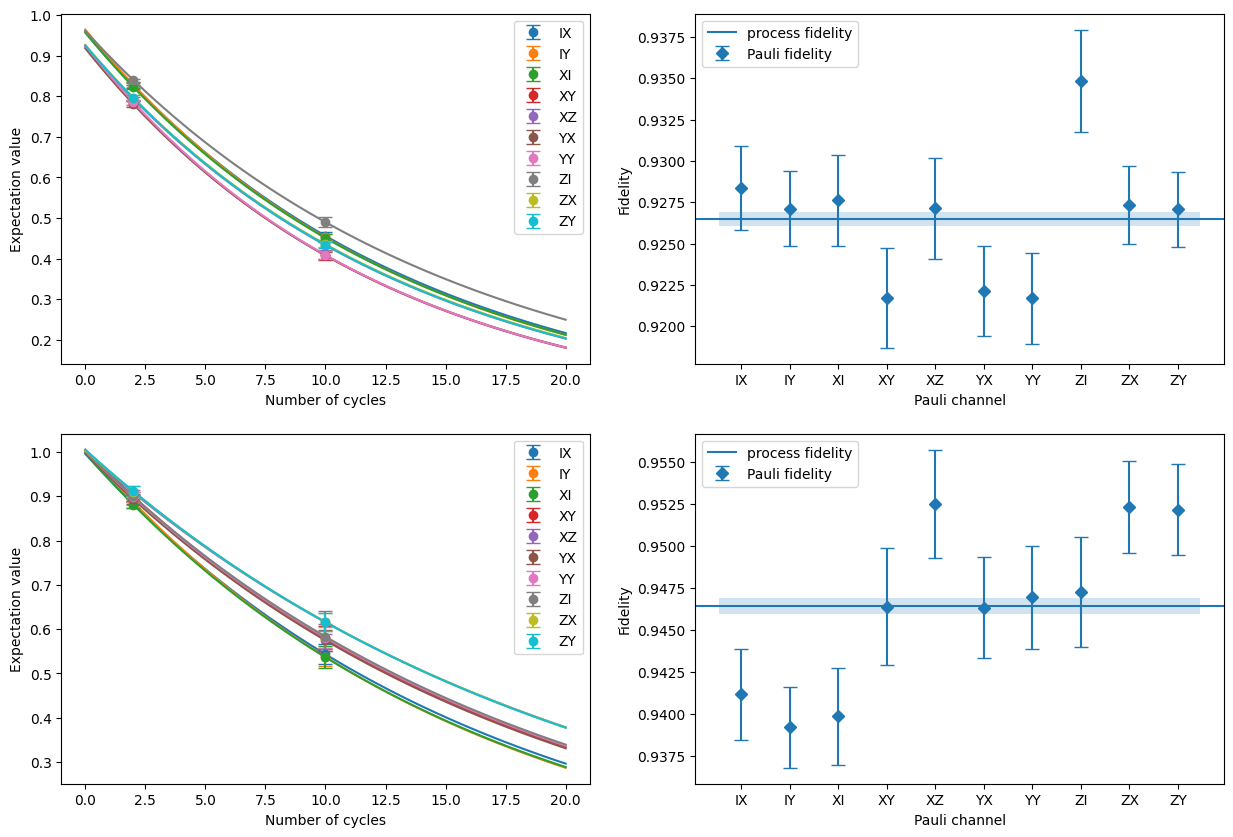

In [10]:
results.analyze()